In [1]:
import os
import shutil
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# """
# this code is used for removing redundant files from labels folder.
# """
# labels_dir = 'data/labels/'
# unnecessary_dir = 'data/unnecessary_labels/'

# os.makedirs(unnecessary_dir, exist_ok=True)

# for label_file in os.listdir(labels_dir):
#     # Move files with underscores in the name to the unnecessary folder
#     if '_' in label_file:
#         shutil.move(os.path.join(labels_dir, label_file), os.path.join(unnecessary_dir, label_file))

# print("Unnecessary label files have been moved.")


c:\Users\yehia\anaconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


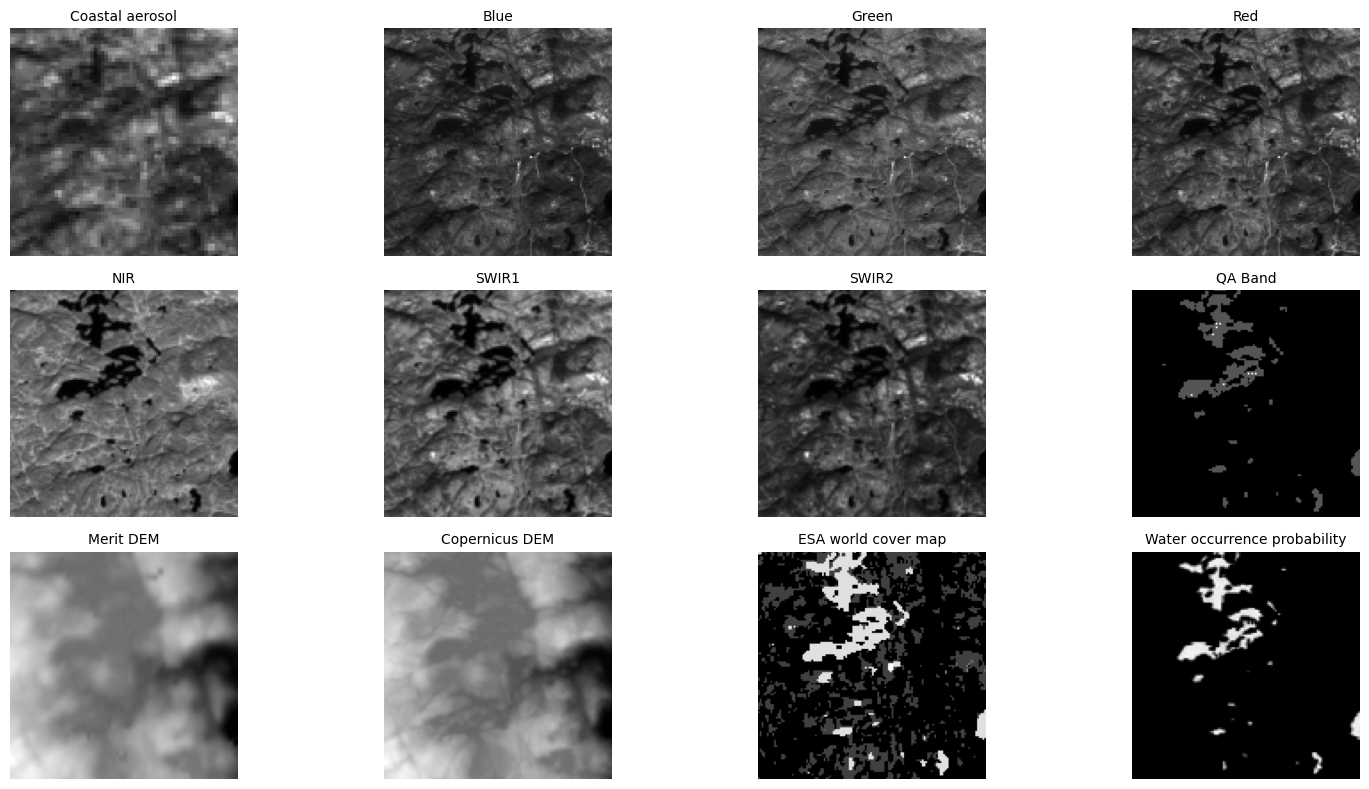

In [3]:
"""
this part of the code used to load one file from images folder and visualizing each of its band's separately.
each image has 12- Bands, their names are written in order to view the name of each band with the image.
"""



def plot_bands(image, band_names, bands_per_row=4):
    n_bands = image.shape[0]
    rows = n_bands // bands_per_row + (n_bands % bands_per_row > 0)
    fig, axes = plt.subplots(rows, bands_per_row, figsize=(16, 8))
    
    for i in range(n_bands):
        row, col = divmod(i, bands_per_row)
        ax = axes[row, col]
        ax.imshow(image[i], cmap='gray')
        ax.set_title(band_names[i], fontsize=10)
        ax.axis('off')

    # Hide any empty subplots
    for i in range(n_bands, rows * bands_per_row):
        fig.delaxes(axes.flat[i])
    
    plt.tight_layout()
    plt.show()


# Band names (in order)
band_names = [
    "Coastal aerosol", "Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2", 
    "QA Band", "Merit DEM", "Copernicus DEM", "ESA world cover map", 
    "Water occurrence probability"
]

# Load an example image
image_path = 'data/images/0.tif' 
with rasterio.open(image_path) as src:
    multispectral_image = src.read()  # (12, 128, 128) - all 12 bands

# Visualize all bands in a grid
plot_bands(multispectral_image, band_names)


In [4]:
"""
this funtion is for visualizing composites, it took 3-Bands and visualize them
"""
def show_composite(image, band_1, band_2, band_3, title):
    rgb_image = np.dstack((image[band_1], image[band_2], image[band_3]))
    rgb_image = rgb_image / np.max(rgb_image)  # Normalize for display
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


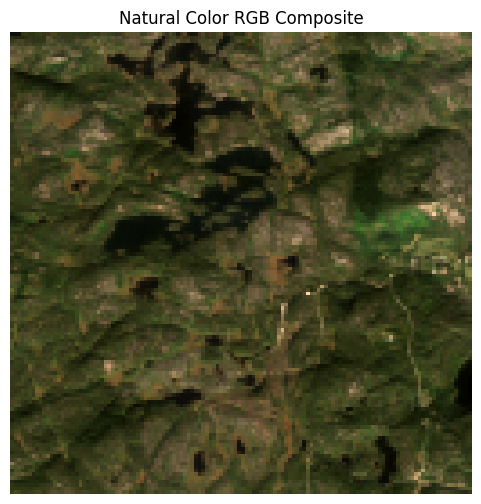

In [5]:
# Visualizing RGB Composite
show_composite(multispectral_image, 3, 2, 1, title="Natural Color RGB Composite") # R_Band:3, G_Band:2, B_band: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


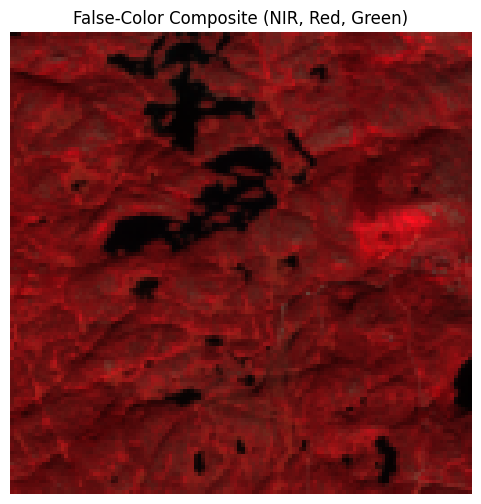

In [6]:
# Visualizing False-Color Composite
show_composite(multispectral_image, 4, 3, 2, title="False-Color Composite (NIR, Red, Green)") # NIR_Band:4, R_Band:3, G_band: 2


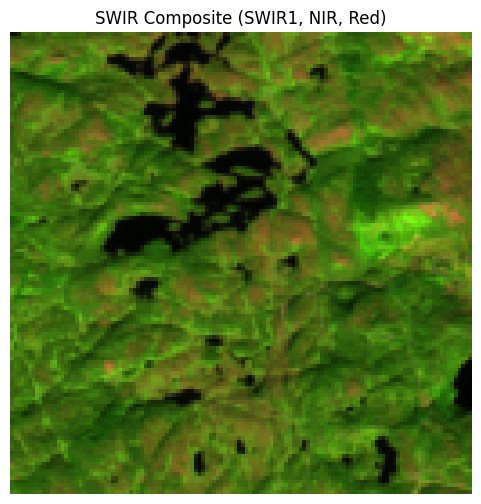

In [7]:
# Visualizing SWIR Composite
show_composite(multispectral_image, 5, 4, 3, title="SWIR Composite (SWIR1, NIR, Red)") # SWIR1_Band:5, NIR_Band:4, R_band: 3


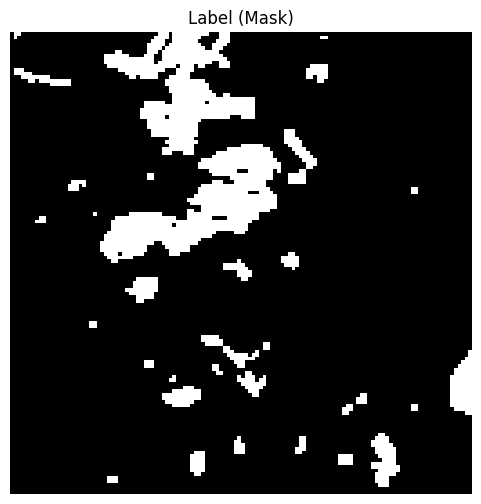

In [8]:
# Visualizing the label(Mask) of the image
label_path = f'data/labels/0.png'

label = Image.open(label_path)

# Plot the label image
plt.figure(figsize=(6, 6))
plt.imshow(label, cmap='gray')
plt.title('Label (Mask)')
plt.axis('off')
plt.show()


In [9]:
"""
This part of the code is responsible for loading, normalizing, augmenting, and preparing the dataset.
the pipeline has many steps, each one has explanation.
"""

# Constants
IMAGE_DIR = 'data/images'
LABEL_DIR = 'data/labels'
IMG_SIZE = (128, 128)  # Image size (width, height)
N_BANDS = 12  # Number of spectral bands

# Step 1: Compute Global Min and Max Values
def compute_global_min_max(image_dir):
    """
    Compute global min and max for each band across all images.
    """
    min_values = np.full(N_BANDS, np.inf)
    max_values = np.full(N_BANDS, -np.inf)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        with rasterio.open(img_path) as src:
            image = src.read()  # (bands, height, width)
            min_values = np.minimum(min_values, np.min(image, axis=(1, 2)))
            max_values = np.maximum(max_values, np.max(image, axis=(1, 2)))
    
    return min_values, max_values

# Step 2: Load and Normalize Data Using Global Min and Max Values
def load_image(image_path, global_min, global_max):
    """
    Load a .tif multispectral image and normalize each band using global min and max values.
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        # Normalize each band using global min and max values
        normalized_image = (image - global_min[:, np.newaxis, np.newaxis]) / \
                           (global_max[:, np.newaxis, np.newaxis] - global_min[:, np.newaxis, np.newaxis])
    return np.moveaxis(normalized_image, 0, -1)  # (height, width, bands)

def load_label(label_path):
    """
    Load a .png label mask.
    """
    label = Image.open(label_path)
    label = np.array(label)  
    return label


def load_data(image_dir, label_dir, global_min, global_max):
    """
    Load all images and labels, normalize, and return them as NumPy arrays.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    images, labels = [], []
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)

        images.append(load_image(img_path, global_min, global_max))
        labels.append(load_label(lbl_path))

    return np.array(images), np.array(labels)

# Step 3: Augment the Data

def augment(image, label):
    """
    Apply random augmentations to the image and label.
    """
    # Add channel dimension to label if it doesn't exist
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)
    
    # Horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    
    # Vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
    
    # Random rotation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        label = tf.image.rot90(label)
    
    # Remove channel dimension from label after augmentations
    if len(label.shape) == 3 and label.shape[-1] == 1:
       label = tf.squeeze(label, axis=-1)

    return image, label


# Step 4: Prepare the Dataset

def prepare_dataset(images, labels, batch_size, augment_data=True):
    """
    Prepare the dataset using TensorFlow's `tf.data.Dataset`.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # if augment_data:
    #     dataset = dataset.map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Step 5: Split the Data into Train/Validation/Test

def split_data(images, labels, test_size=0.15, val_size=0.15):
    """
    Split the data into training, validation, and test sets.
    Where 70% for training, 15% for validation, 15% for testing.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=test_size+val_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 6: Main Pipeline

def preprocessing_pipeline(image_dir=IMAGE_DIR, label_dir=LABEL_DIR, batch_size=32):
    """
    Complete preprocessing pipeline to load, normalize, augment, and prepare the dataset.
    """
    # Compute global min and max values
    global_min, global_max = compute_global_min_max(image_dir)
    
    # Load and normalize the data
    images, labels = load_data(image_dir, label_dir, global_min, global_max)
    
    # Split into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)

    # Prepare TensorFlow datasets
    train_dataset = prepare_dataset(X_train, y_train, batch_size=batch_size, augment_data=True)
    val_dataset = prepare_dataset(X_val, y_val, batch_size=batch_size, augment_data=False)
    test_dataset = prepare_dataset(X_test, y_test, batch_size=batch_size, augment_data=False)

    return train_dataset, val_dataset, test_dataset


In [10]:
# Running the pipeline
train_ds, val_ds, test_ds = preprocessing_pipeline()

print("Preprocessing complete. Datasets are ready for model training.")

Preprocessing complete. Datasets are ready for model training.


In [11]:
def compute_statistics(dataset):
    """Compute and print basic statistics of the dataset."""
    for images, labels in dataset.take(1):  # Take one batch
        print("Image statistics:")
        print(f"Image shape: {images.shape}")
        print(f"Image data type: {images.dtype}")
        print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
        print(f"Max pixel value: {tf.reduce_max(images).numpy()}")
        print(f"Mean pixel value: {tf.reduce_mean(images).numpy()}")
        print(f"Standard deviation: {tf.math.reduce_std(images).numpy()}")
        
        print("\nLabel statistics:")
        print(f"Label shape: {labels.shape}")
        print(f"Label data type: {labels.dtype}")
        print(f"Unique label values: {np.unique(labels.numpy())}")

compute_statistics(train_ds)


Image statistics:
Image shape: (32, 128, 128, 12)
Image data type: <dtype: 'float64'>
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.19192693270097994
Standard deviation: 0.2053256780879069

Label statistics:
Label shape: (32, 128, 128)
Label data type: <dtype: 'uint8'>
Unique label values: [0 1]


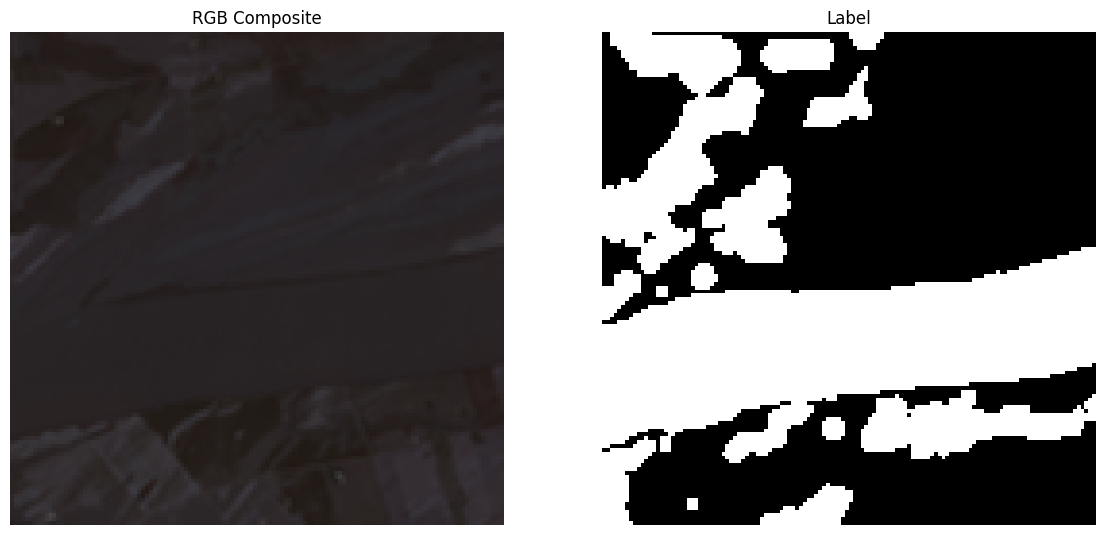

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_rgb_and_label(image, label):
    """
    Visualize an RGB composite image and its corresponding label side by side.
    to make sure the pipeline work correctly without problems.
    """

    red = image[:, :, 1]  # Red band
    green = image[:, :, 2]  # Green band
    blue = image[:, :, 3]  # Blue band

    rgb_image = np.stack([red, green, blue], axis=-1)  # Stack into RGB format
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display RGB Image
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Composite')
    axs[0].axis('off')
    
    # Display Label Image
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Label')
    axs[1].axis('off')
    
    plt.show()

# Visualize one sample from the training dataset
for image, label in train_ds.take(1):
    # Convert tensors to numpy arrays
    image_np = image.numpy()[0]  # Get the first sample
    label_np = label.numpy()[0]  # Get the corresponding label
    visualize_rgb_and_label(image_np, label_np)
    break


In [13]:
def unet_model(input_shape=(128, 128, 12), num_classes=1):
    """
    Build a U-Net model for image segmentation.
    
    Parameters:
    - input_shape: Shape of the input image (height, width, channels)
    - num_classes: Number of output classes (for binary classification, it's 1)
    
    Returns:
    - model: U-Net model instance
    """
    inputs = Input(input_shape)
    
    # Encoding path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)
    
    # Decoding path
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4], axis=-1)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3], axis=-1)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2], axis=-1)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1], axis=-1)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net model
model = unet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  6976        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',                  # Monitor the validation loss
    patience=15,                          # Number of epochs to wait for improvement
    restore_best_weights=True            # Restore model with the best weights
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Initialize metrics
precision = Precision(name='precision')
recall = Recall(name='recall')
iou = MeanIoU(num_classes=2, name='iou')

# Compile the model with specified metrics
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, iou]
)


In [15]:
# Train the model
history = model.fit(
    train_ds,                            # Training dataset
    validation_data=val_ds,              # Validation dataset
    epochs=50,                           # Number of epochs
    callbacks=[early_stopping, reduce_lr]               # List of callbacks
)


Epoch 1/50
7/7 [==============================] - 33s 2s/step - loss: 0.6225 - accuracy: 0.6829 - precision: 0.3851 - recall: 0.2646 - iou: 0.3631 - val_loss: 1.5376 - val_accuracy: 0.7633 - val_precision: 0.9969 - val_recall: 0.0875 - val_iou: 0.3703 - lr: 3.0000e-04
Epoch 2/50
7/7 [==============================] - 2s 324ms/step - loss: 0.7278 - accuracy: 0.7827 - precision: 0.6175 - recall: 0.5431 - iou: 0.3631 - val_loss: 0.5742 - val_accuracy: 0.8272 - val_precision: 0.7924 - val_recall: 0.4523 - val_iou: 0.3703 - lr: 3.0000e-04
Epoch 3/50
7/7 [==============================] - 2s 351ms/step - loss: 0.5226 - accuracy: 0.8312 - precision: 0.8883 - recall: 0.4390 - iou: 0.3631 - val_loss: 0.4413 - val_accuracy: 0.8302 - val_precision: 0.9936 - val_recall: 0.3473 - val_iou: 0.3703 - lr: 3.0000e-04
Epoch 4/50
7/7 [==============================] - 2s 335ms/step - loss: 0.3960 - accuracy: 0.8437 - precision: 0.9366 - recall: 0.4605 - iou: 0.3631 - val_loss: 0.3725 - val_accuracy: 0.841

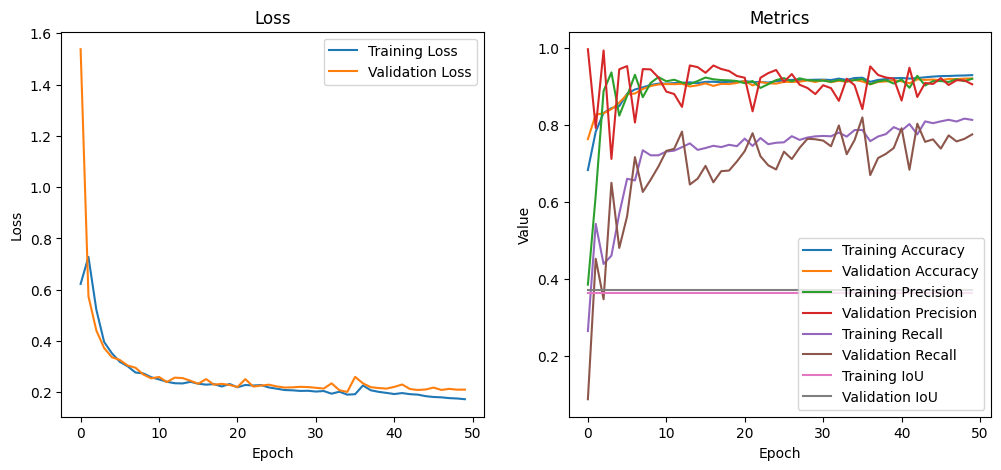

In [16]:
# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Metrics
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.plot(history.history['iou'], label='Training IoU')
    plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.title('Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

# Visualize the training history
plot_metrics(history)

In [17]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall, test_iou = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test IoU: {test_iou}")


2/2 [==============================] - 0s 47ms/step - loss: 0.2043 - accuracy: 0.9262 - precision: 0.9009 - recall: 0.6973 - iou: 0.4028
Test Loss: 0.20433494448661804
Test Accuracy: 0.9262217879295349
Test Precision: 0.900880753993988
Test Recall: 0.6972916722297668
Test IoU: 0.40277695655822754


1/1 [==============================] - 0s 31ms/step


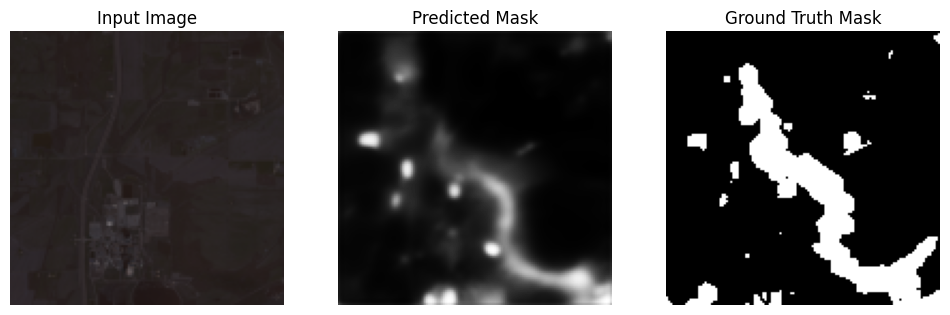

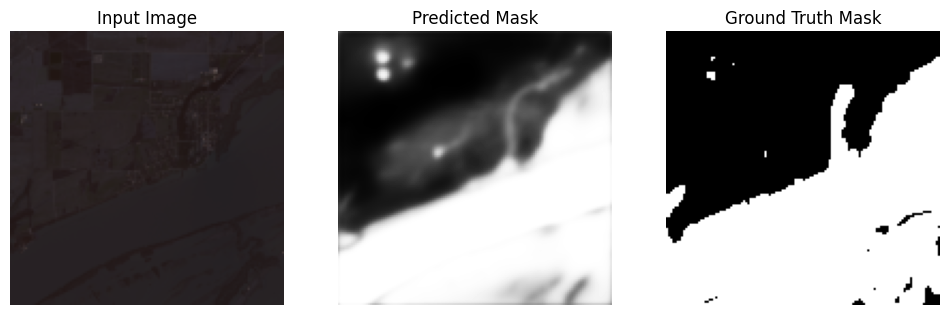

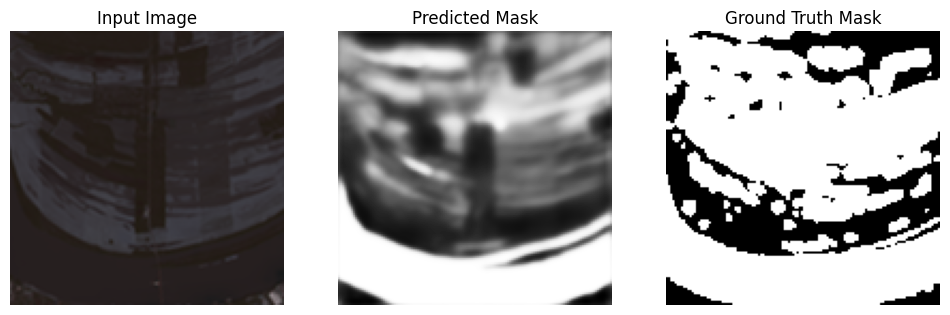

In [23]:
# Predict on test dataset and visualize a few predictions alongside true labels
for images, true_labels in test_ds.take(1):
    # Make predictions for the batch
    pred_masks = model.predict(images)

    for i in range(3):  # Visualize 3 samples
        plt.figure(figsize=(12, 6))

        # Extract RGB bands (1, 2, 3)
        rgb_image = images[i][:, :, 1:4]

        # Display the RGB Image
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_image)
        plt.title('Input Image')
        plt.axis('off')

        # Display the Predicted Mask
        plt.subplot(1, 3, 2)
        plt.imshow(pred_masks[i], cmap='gray') 
        plt.title('Predicted Mask')
        plt.axis('off')

        # Display the Ground Truth Mask
        plt.subplot(1, 3, 3)
        plt.imshow(true_labels[i].numpy(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.show()


In [24]:
# Save the trained model
model.save('U-NET_Model.h5')

In [25]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('U-NET_Model.h5', custom_objects={'Precision': tf.keras.metrics.Precision,
                                                           'Recall': tf.keras.metrics.Recall,
                                                           'MeanIoU': tf.keras.metrics.MeanIoU})


1/1 [==============================] - 0s 22ms/step


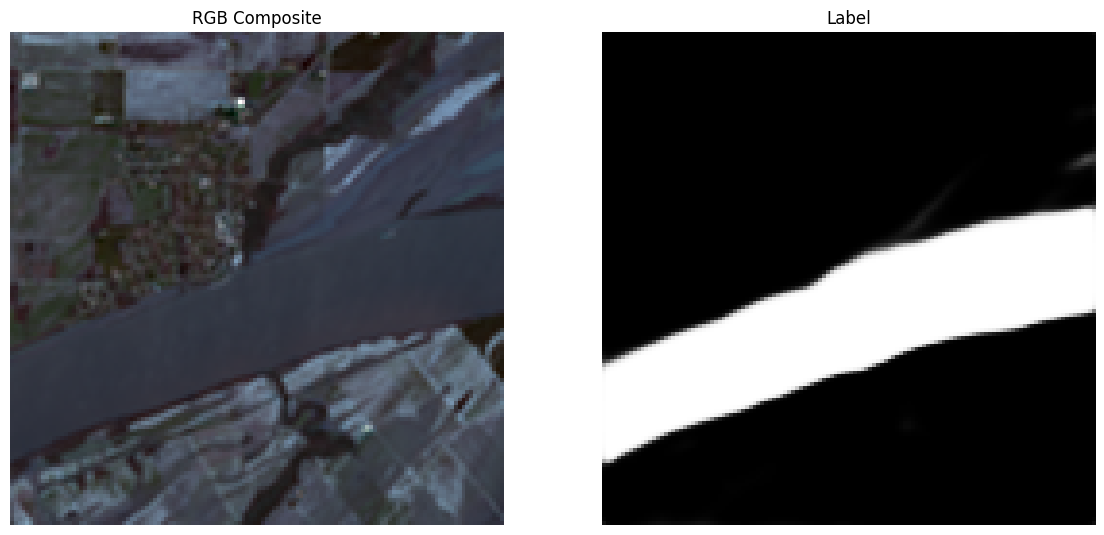

In [51]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf

def load_image(image_path):
    """
    Load a .tif multispectral image and normalize each band separately using its own min and max values
    (as we did in the data used for training the model).
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        
        # Calculate min and max for each band separately
        min_values = np.min(image, axis=(1, 2))
        max_values = np.max(image, axis=(1, 2))
        
        # Normalize each band using its own min and max values
        normalized_image = (image - min_values[:, np.newaxis, np.newaxis]) / \
                           (max_values[:, np.newaxis, np.newaxis] - min_values[:, np.newaxis, np.newaxis])
        
    return np.moveaxis(normalized_image, 0, -1)  # (height, width, bands)

def create_rgb_composite(image):
    """
    Create an RGB composite from the normalized image.
    """
    # Extract RGB bands (1, 2, 3)
    red = image[:, :, 1]  # Red band
    green = image[:, :, 2]  # Green band
    blue = image[:, :, 3]  # Blue band

    # Stack the channels into an RGB composite image
    rgb_image = np.stack([red, green, blue], axis=-1)
    return rgb_image

def visualize_rgb_and_label(image, label):
    """
    Visualize an RGB composite image and its corresponding label side by side.
    """
    # Create RGB composite
    rgb_image = create_rgb_composite(image)
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display RGB Image
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Composite')
    axs[0].axis('off')
    
    # Display Label Image
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Mask Label for the image')
    axs[1].axis('off')
    
    plt.show()

def preprocess_and_predict(image_path, model):
    """
    Preprocess a new image and predict the mask using the provided model.
    """

    new_image = load_image(image_path)
    
    # Add batch dimension to match input shape: (1, 128, 128, 12)
    new_image = tf.expand_dims(new_image, axis=0)
    
    # Predict the mask using the loaded model
    predicted_mask = model.predict(new_image)
    
    # Convert from tensor to numpy for display
    image_for_display = new_image[0].numpy()
    # Remove the batch dimenion
    predicted_mask_for_display = predicted_mask.squeeze()
    
    # Visualize the RGB composite and predicted mask
    visualize_rgb_and_label(image_for_display, predicted_mask_for_display)

# Test with an image
image_path = 'data/images/22.tif'
preprocess_and_predict(image_path, loaded_model)

